# Slope Fitting - Exploring Methods 

Words, words, words.

#### Note
This notebook serves merely as a demonstration of the possible ways to measure slope. To actually use these metrics, implementations are available in slf/fit.py. This module uses a standardized API and offers and has a cleaner organization in ways that avoids the gymnastics used below to deal with array shape and log status.

In [35]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.optimize import curve_fit
from sklearn.linear_model import RANSACRegressor

In [2]:
import sys
sys.path.append('/Users/tom/Documents/GitCode/SlopeFitOscs/')

# Import custom slope fitting code
from slf.plts.psd import *
from slf.core.utils import *

# Load FOOOF
from fooof import FOOOF
from fooof.funcs import loglorentzian_nk_function as expf

In [3]:
# Load data from Jorge (Chicage group doing slope fitting)
dat = np.load('../data/data-for-tom.npy').item()

In [4]:
# Get freqs & unembed from being an array of arrays
freqs = dat['f']
freqs = np.array([f[0] for f in freqs])

/Users/tom/Documents/GitCode/SlopeFitOscs/slf/plts/psd.py:16: RuntimeWarning: divide by zero encountered in log10
  freqs = np.log10(freqs)


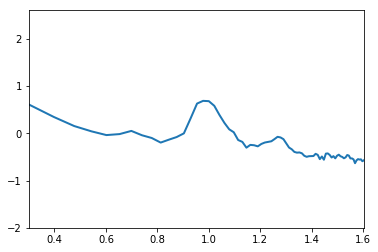

In [5]:
# Check plot - single PSD
plt_psd_1(freqs, dat[0][0]['eyesc'])

/Users/tom/Documents/GitCode/SlopeFitOscs/slf/plts/psd.py:16: RuntimeWarning: divide by zero encountered in log10
  freqs = np.log10(freqs)


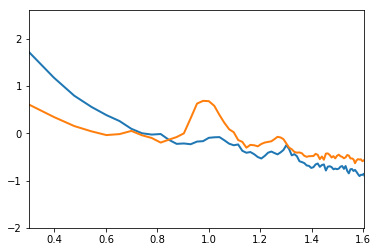

In [6]:
# Compare eyes open / eyes closed: single subject, single channel
plt_psd_2(freqs, dat[0][0]['eyeso'], freqs, dat[0][0]['eyesc'])

## FOOFing Data


                                          FOOOF - PSD MODEL                                          

                      The input PSD was modeled in the frequency range 3-40 Hz                      
                                 Frequency Resolution is 0.50 Hz 
                                  
                              Background Parameters (offset, slope):                                
                                           0.5498, 0.6997                                           

                                      2 oscillations were found:                                     
                                 CF:  10.07, Amp:  0.837, BW:  2.67                                 
                                 CF:  18.31, Amp:  0.259, BW:  3.10                                 

                                      R^2 of model fit is 0.9655                                     

                            Root mean squared error of model fit is 0.0510         

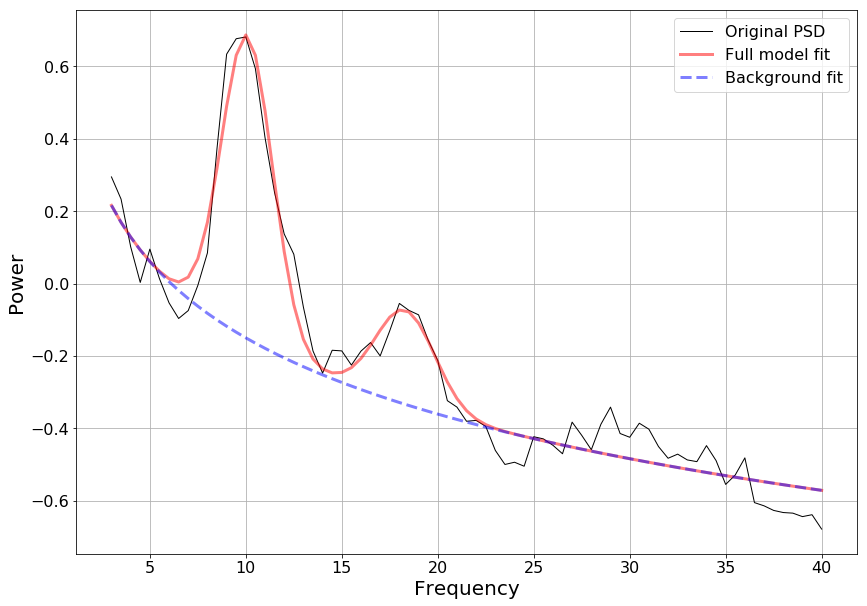

In [7]:
# Grab PSD of interest
psd = dat[0][1]['eyesc']

# Initialize FOOOF model
fm = FOOOF(bandwidth_limits=[1, 8])

# Fit FOOOF
fm.model(freqs, psd, [3, 40])
sl_fooof = -fm.background_params_[1]

# Methods for Fitting PSD Slope

Words, words, words

In [8]:
# Set a PSD to slope-fit
psd = dat[0][1]['eyesc']
freqs_ext, psd_ext = extract_psd(freqs, psd, 3, 40)

# Add constant for fitting with statsmodels
fx = sm.add_constant(np.log10(freqs_ext))

## Linear Fits (in log-log)

Words, words, words.

### Simple Linear Fit

Fit with Ordinary Least Squares (OLS)

In [9]:
# Fit slope - simple linear fit
fit_ols = sm.OLS(np.log10(psd_ext), fx).fit()
sl_ols = fit_ols.params[1]

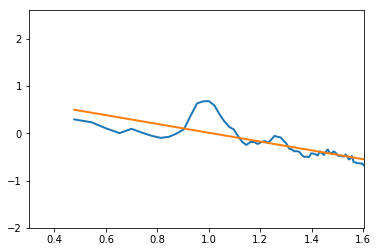

In [10]:
# Check the simple linear slope fit
plt_psd_2(freqs_ext, psd_ext, freqs_ext, np.power(10, fit_ols.fittedvalues), log_f=True)

### Robust Slope Fitting with RLM

In [11]:
# Fit slope - robust linear fit to log-log PSD
fit_rlm = sm.RLM(np.log10(psd_ext), fx).fit()
sl_rlm = fit_rlm.params[1]

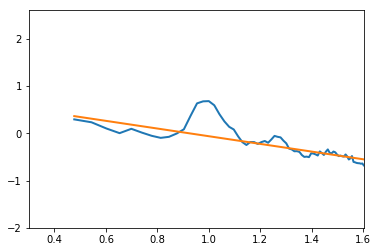

In [12]:
# Check the robust linear slope fit
plt_psd_2(freqs_ext, psd_ext, freqs_ext, np.power(10, fit_rlm.fittedvalues), log_f=True)

### Robust Fitting with RANSAC

In [13]:
# Reshape freqs for RANSAC fit
freqs_ext = freqs_ext.reshape([len(freqs_ext), 1])

In [14]:
# Initialize and fit with RANSAC
ransac_model = RANSACRegressor()
ransac_model.fit(np.log10(freqs_ext), np.log10(psd_ext))
sl_ran = ransac_model.estimator_.coef_[0][0]

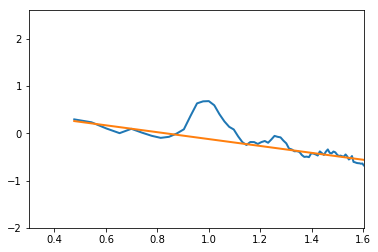

In [15]:
# Plot the slope fit, from RANSAC
plt_psd_2(freqs_ext, psd_ext, freqs_ext, np.power(10, ransac_model.predict(np.log10(freqs_ext))))

## Slope Fitting Excluding Alpha

Words, words, words.

In [16]:
# Exclude predefined alpha range
freqs_alph, psd_alph = exclude_psd(freqs_ext, psd_ext, [7, 14])

# Reset freqs, with constant
fx = sm.add_constant(np.log10(freqs_alph))

### RLM Slope Fitting Excluding Generic Alpha Band

In [17]:
# Robust fit slope without alpha range
fit_rlm_alph = sm.RLM(np.log10(psd_alph), fx).fit()
sl_rlm_alph = fit_rlm_alph.params[1]

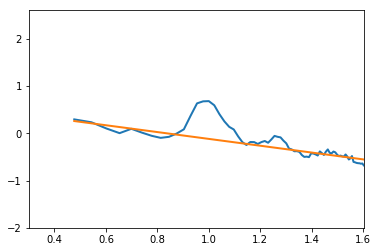

In [18]:
# Plot the slope fit, with alpha exclusion range (note plots original PSD with alpha included)
plt_psd_2(freqs_ext, psd_ext, freqs_alph, np.power(10, fit_rlm_alph.fittedvalues), log_f=True)

### RANSAC Slope Fitting Excluding Generic Alpha Band

In [19]:
# Fit alpha-exclusion with RANSAC
ransac_model_alph = RANSACRegressor()
ransac_model_alph.fit(np.log10(freqs_alph), np.log10(psd_alph))
sl_ran_alph = ransac_model_alph.estimator_.coef_[0][0]

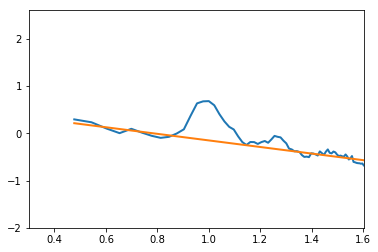

In [20]:
# Plot the slope fit, with osc excluded (note: plots original PSD with oscs included)
plt_psd_2(freqs_ext, psd_ext, freqs_alph, np.power(10, ransac_model_alph.predict(np.log10(freqs_alph))))

## Slope Fitting Excluding Oscillations

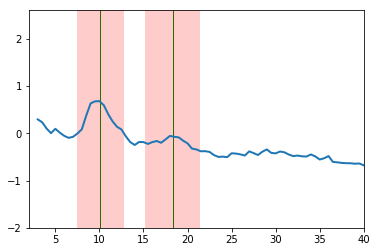

In [21]:
# Get oscillation definitions from FOOOF
cens = fm._gaussian_params[:, 0]
bws = fm._gaussian_params[:, 2]

# Plot PSD with oscillatory regions marked out
m = 2
plt_psd_shade(freqs_ext, psd_ext, cens, bws, m)

In [22]:
# Exclude FOOOF oscillation bands
psd_excl = psd_ext
freqs_excl = freqs_ext

for cen, bw in zip(cens, bws):
    freqs_excl, psd_excl = exclude_psd(freqs_excl, psd_excl, [cen-m*bw, cen+m*bw])

### RLM Slope Fitting Excluding Oscillatory Bands

In [23]:
# Robust fit slope without FOOF oscillation bands
fx = sm.add_constant(np.log10(freqs_excl))
fit_rlm_excl = sm.RLM(np.log10(psd_excl), fx).fit()
sl_rlm_excl = fit_rlm_excl.params[1]

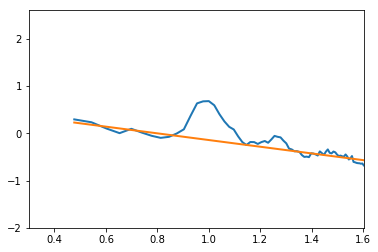

In [24]:
# Plot the slope fit, with osc excluded (note: plots original PSD with oscs included)
plt_psd_2(freqs_ext, psd_ext, freqs_excl, np.power(10, fit_rlm_excl.fittedvalues), log_f=True)

### RANSAC Slope Fitting Excluding Oscillatory Bands

In [25]:
# Fit alpha-exclusion with RANSAC
ransac_model_excl = RANSACRegressor()
ransac_model_excl.fit(np.log10(freqs_excl), np.log10(psd_excl))
sl_ran_excl = ransac_model_excl.estimator_.coef_[0][0]

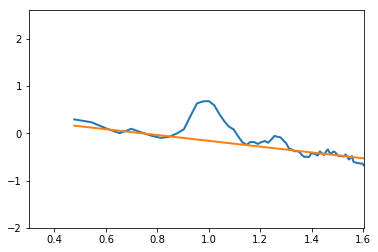

In [26]:
# Plot the slope fit, with osc excluded (note: plots original PSD with oscs included)
plt_psd_2(freqs_ext, psd_ext, freqs_excl, np.power(10, ransac_model_excl.predict(np.log10(freqs_excl))))

## Exponential Fits

Words, words, words.

### Exponential Fit

In [27]:
# Fit exponential 1/f, with scipy curve_fit
fit_exp, _ = curve_fit(expf, np.squeeze(freqs_ext), np.squeeze(np.log10(psd_ext)), p0=[1, 1])
sl_exp = -fit_exp[1]

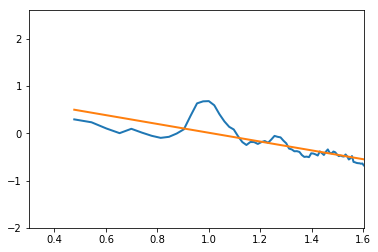

In [28]:
# Plot the slope fit, from exponential fit
plt_psd_2(freqs_ext, psd_ext, freqs_ext, np.power(10, expf(freqs_ext, *fit_exp)))

### Exponential Fit Excluding Alpha Region

In [29]:
# Fit exponential 1/f, with scipy curve_fit, excluding alpha range
fit_exp_alph, _ = curve_fit(expf, np.squeeze(freqs_alph), np.squeeze(np.log10(psd_alph)), p0=[1, 1])
sl_exp_alph = -fit_exp_alph[1]

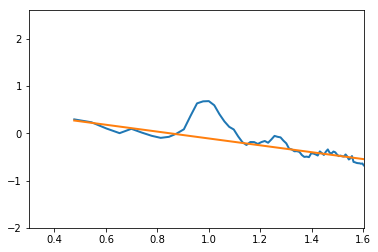

In [30]:
# Plot the slope fit, from alpha region excluded fit (note: plots original PSD with oscs included)
plt_psd_2(freqs_ext, psd_ext, freqs_alph, np.power(10, expf(freqs_alph, *fit_exp_alph)))

### Exponential Fit Excluding Oscillation Regions

In [31]:
# Fit exponential 1/f, with scipy curve_fit, excluding oscillatory regions
fit_exp_excl, _ = curve_fit(expf, np.squeeze(freqs_excl), np.squeeze(np.log10(psd_excl)), p0=[1, 1])
sl_exp_excl = -fit_exp_excl[1]

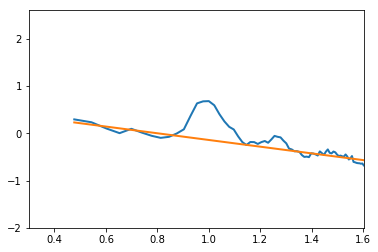

In [32]:
# Plot the slope fit, with osc excluded (note: plots original PSD with oscs included)
plt_psd_2(freqs_ext, psd_ext, freqs_excl, np.power(10, expf(freqs_excl, *fit_exp_excl)))

# Compare Slope Fits


In [33]:
# Print out results across all the different approaches
print('SLOPE FIT RESULTS \n')
print('OLS: \t\t\t', sl_ols)
print('RLM: \t\t\t', sl_rlm)
print('RLM-Exclude Alpha:\t', sl_rlm_alph)
print('RLM-Exclude Oscs:\t', sl_rlm_excl)
print('RANSAC:\t\t\t', sl_ran)
print('RANSAC-Exclude Alpha:\t', sl_ran_alph)
print('RANSAC-Exclude Oscs:\t', sl_ran_excl)
print('EXP: \t\t\t', sl_exp)
print('EXP-Exclude Alpha:\t', sl_exp_alph)
print('EXP-Exclude Oscs:\t', sl_exp_excl)
print('FOOOF:\t\t\t', sl_fooof)

SLOPE FIT RESULTS 

OLS: 			 -0.933060914186
RLM: 			 -0.813382243358
RLM-Exclude Alpha:	 -0.722897254535
RLM-Exclude Oscs:	 -0.70877580837
RANSAC:			 -0.729372985505
RANSAC-Exclude Alpha:	 -0.696518836658
RANSAC-Exclude Oscs:	 -0.615011760973
EXP: 			 -0.933060913135
EXP-Exclude Alpha:	 -0.726463628412
EXP-Exclude Oscs:	 -0.70999498044
FOOOF:			 -0.699727371121


In [34]:
# Order slope fits by magnitude
all_sl_fits = [(sl_ols, 'OLS'), (sl_fooof, 'FOOOF'),
               (sl_rlm, 'RLM'), (sl_rlm_alph, 'RLM-EA'), (sl_rlm_excl, 'RLM-EO'),
               (sl_ran, 'RAN'), (sl_ran_alph, 'RAN-EA'), (sl_ran_excl, 'RAN-EO'),
               (sl_exp, 'EXP'), (sl_exp_alph, 'EXP-EA'), (sl_exp_excl, 'EXP-EO')]
all_sl_fits.sort()
all_sl_fits.reverse()

# Print out in order of slope fit magnitude
print('SLOPE FIT RESULTS (SORTED):')
for fit in all_sl_fits:
    print('\t {:1.5f} \t {}'.format(*fit))

SLOPE FIT RESULTS (SORTED):
	 -0.61501 	 RAN-EO
	 -0.69652 	 RAN-EA
	 -0.69973 	 FOOOF
	 -0.70878 	 RLM-EO
	 -0.70999 	 EXP-EO
	 -0.72290 	 RLM-EA
	 -0.72646 	 EXP-EA
	 -0.72937 	 RAN
	 -0.81338 	 RLM
	 -0.93306 	 EXP
	 -0.93306 	 OLS
